In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)
# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12

## WeakSINDy on their clean data

Shape of u :  (1024, 251)
Shape of t:  (251,)
Shape of x:  (1024,)


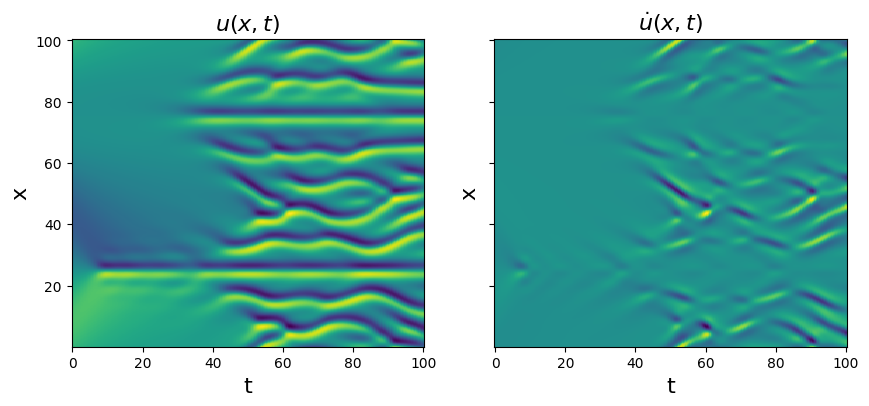

In [2]:
# Load and plot the data
data = loadmat("kuramoto_sivishinky_data.mat")
time = np.ravel(data["tt"])
x = np.ravel(data["x"])
u = data["uu"]

print("Shape of u : ", u.shape)
print("Shape of t: ", time.shape)
print("Shape of x: ", x.shape)
dt = time[1] - time[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(time, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 2, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$", fontsize=16)
plt.show()

u = u.reshape(len(x), len(time), 1)

In [3]:
dt

np.float64(0.4)

In [4]:
u.shape

(1024, 251, 1)

In [5]:
x.shape, time.shape

((1024,), (251,))

In [6]:
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)

# Run optimizers

print("STLSQ optimizer: ")
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: ")
optimizer = ps.SR3(
    reg_weight_lam=0.8, max_iter=1000, regularizer="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:")
optimizer = ps.SR3(
    reg_weight_lam=0.2, max_iter=1000, regularizer="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with kappa=1e-20: ")
optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: ")
optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("FROLS optimizer: ")
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()

STLSQ optimizer: 
(x0)' = -1.000 x0_11 + -1.000 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111
SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: 
(x0)' = -0.999 x0_11 + -0.999 x0_1111 + -1.002 x0x0_1
SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:
(x0)' = -0.837 x0_11 + -0.834 x0_1111 + -0.908 x0x0_1 + 0.004 x0^2x0_1111
SSR optimizer with kappa=1e-20: 
(x0)' = -1.000 x0_11 + -1.000 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111
SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: 
(x0)' = -0.999 x0_11 + -1.000 x0_1111 + -1.002 x0x0_1
FROLS optimizer: 
(x0)' = -1.000 x0_11 + -1.000 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


In [7]:
# Get average SR3 performance as function of the noise level.
cross_val_runs = 1
u = np.squeeze(u)
rmse = mean_squared_error(u, np.zeros(u.shape))
noise_levels = np.linspace(0, rmse / 2.0, 5)
delta_c1 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c2 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c3 = np.zeros((cross_val_runs, len(noise_levels)))

# Make a weak form library with high-resolution
pde_lib = ps.WeakPDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    K=400,
    is_uniform=True,
)
# Pick an optimizer with some plausible hyperparameters
optimizer = ps.SR3(reg_weight_lam=1, max_iter=1000, regularizer="l0", normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# Loop over noisy data and cross-validate
for i in range(cross_val_runs):
    for j, noise in enumerate(noise_levels):
        u_noisy = u + np.random.normal(0, noise, u.shape)
        u_noisy = np.reshape(u_noisy, (len(x), len(time), 1))
        model.fit(u_noisy,dt)
        model.print()
        c1 = abs(optimizer.coef_[0, 6])
        c2 = abs(optimizer.coef_[0, 3])
        c3 = abs(optimizer.coef_[0, 5])
        delta_c1[i, j] = abs(abs(c1 - 1.0) / c1)
        delta_c2[i, j] = abs(abs(c2 - 1.0) / c2)
        delta_c3[i, j] = abs(abs(c3 - 1.0) / c3)

(x0)' = -0.999 x0_11 + -1.000 x0_1111 + -1.002 x0x0_1
(x0)' = -0.997 x0_11 + -1.001 x0_1111 + -1.003 x0x0_1
(x0)' = -0.014 x0_1 + -1.010 x0_11 + -1.007 x0_1111 + -1.005 x0x0_1 + 0.001 x0^2x0_11
(x0)' = 0.010 x0 + -1.002 x0_11 + -1.003 x0_1111 + -0.989 x0x0_1 + 0.002 x0^2x0_11
(x0)' = 0.011 x0 + -0.999 x0_11 + -1.000 x0_1111 + -0.999 x0x0_1


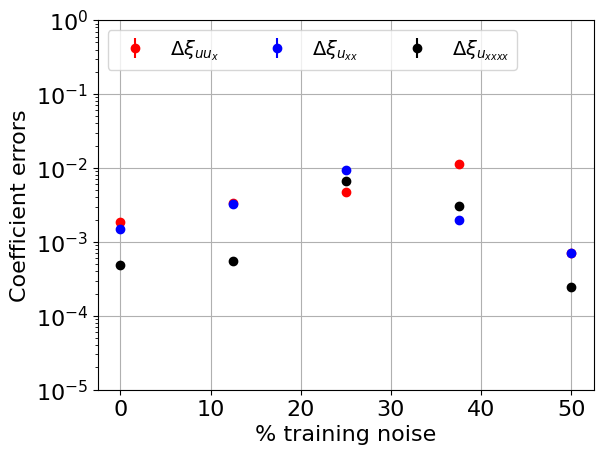

In [8]:
# Find mean and std over the validation runs
delta_c1_mean = np.nanmean(delta_c1, axis=0)
delta_c2_mean = np.nanmean(delta_c2, axis=0)
delta_c3_mean = np.nanmean(delta_c3, axis=0)

delta_c1_std = np.nanstd(delta_c1, axis=0)
delta_c2_std = np.nanstd(delta_c2, axis=0)
delta_c3_std = np.nanstd(delta_c3, axis=0)

# Plot average and standard deviations of the coefficient errors
plt.figure()
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c1_mean,
    yerr=delta_c1_std,
    color="r",
    fmt="o",
    label=r"$\Delta\xi_{uu_x}$",
)
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c2_mean,
    yerr=delta_c2_std,
    color="b",
    fmt="o",
    label=r"$\Delta\xi_{u_{xx}}$",
)
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c3_mean,
    yerr=delta_c3_std,
    color="k",
    fmt="o",
    label=r"$\Delta\xi_{u_{xxxx}}$",
)
plt.yscale("log")
plt.legend(fontsize=14, loc="upper left", ncol=3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
ax = plt.gca()
ax.set_ylim(1e-5, 1)
plt.xlabel("% training noise", fontsize=16)
plt.ylabel("Coefficient errors", fontsize=16)
plt.savefig("SR3_weakformPDE_KS.png")

## WeakSINDy on our clean data

Shape of u :  (2001, 200)
Shape of t:  (2001,)
Shape of x:  (200,)


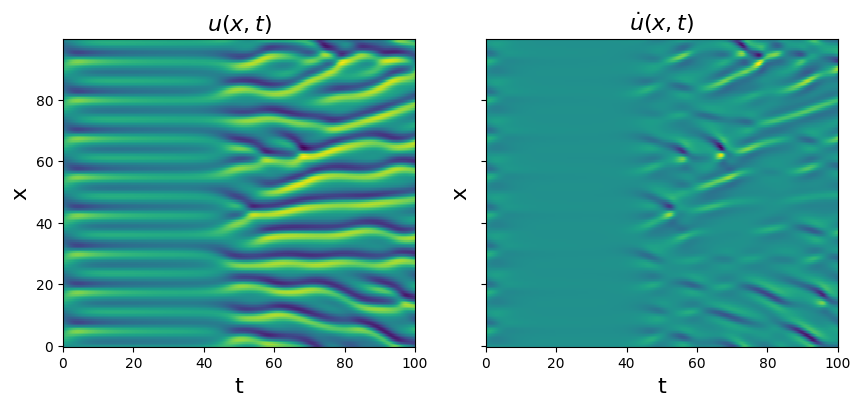

In [9]:
import h5py
from scipy.io import loadmat

with h5py.File("test_solving_euler_ks_clean.h5", "r") as f:
    u = np.array(f["u"])      # shape (Nt, Nx)
    x = np.array(f["x"])      # spatial grid
    t = np.array(f["t"])      # time grid


print("Shape of u : ", u.shape)
print("Shape of t: ", t.shape)
print("Shape of x: ", x.shape)


u = u.T

dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u, shading='auto')
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()



u = u.reshape(len(x), len(t), 1)
#u_dot = u_dot.reshape(len(x), len(t), 1)

In [10]:
u.shape

(200, 2001, 1)

In [11]:
x.shape, t.shape

((200,), (2001,))

In [12]:


dt = dt.astype(np.float64)

In [13]:
dt

np.float64(0.05000000074505806)

In [14]:
XT.shape

(1024, 251, 2)

In [15]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)

# Run optimizers

print("STLSQ optimizer: ")
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: ")
optimizer = ps.SR3(
    reg_weight_lam=0.8, max_iter=1000, regularizer="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:")
optimizer = ps.SR3(
    reg_weight_lam=0.2, max_iter=1000, regularizer="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with kappa=1e-20: ")
optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: ")
optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("FROLS optimizer: ")
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()

STLSQ optimizer: 
(x0)' = 0.001 x0 + -1.003 x0_11 + -1.002 x0_1111 + -0.999 x0x0_1 + -0.001 x0^2x0_1 + 0.044 x0x0_111 + -0.001 x0x0_1111
SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: 
(x0)' = -1.004 x0_11 + -1.003 x0_1111 + -1.002 x0x0_1 + 0.043 x0x0_111
SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:
(x0)' = 0.010 x0 + -0.766 x0_11 + -0.785 x0_1111 + -0.938 x0x0_1
SSR optimizer with kappa=1e-20: 
(x0)' = 0.005 x0 + 0.001 x0^2 + -0.973 x0_11 + -0.983 x0_1111 + -1.055 x0x0_1 + 0.001 x0^2x0_1 + 0.009 x0^2x0_11
SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: 
(x0)' = 0.001 x0 + -1.002 x0_11 + -1.001 x0_1111 + -1.002 x0x0_1 + 0.043 x0x0_111
FROLS optimizer: 
(x0)' = 0.001 x0 + -1.003 x0_11 + -1.002 x0_1111 + -1.000 x0x0_1 + 0.044 x0x0_111


## WeakSINDy on our noisy datasets (Spatially Translated)

### Spatially translated data: Random shift between -3 to 3 pixels

Shape of u :  (2001, 200)
Shape of t:  (2001,)
Shape of x:  (200,)


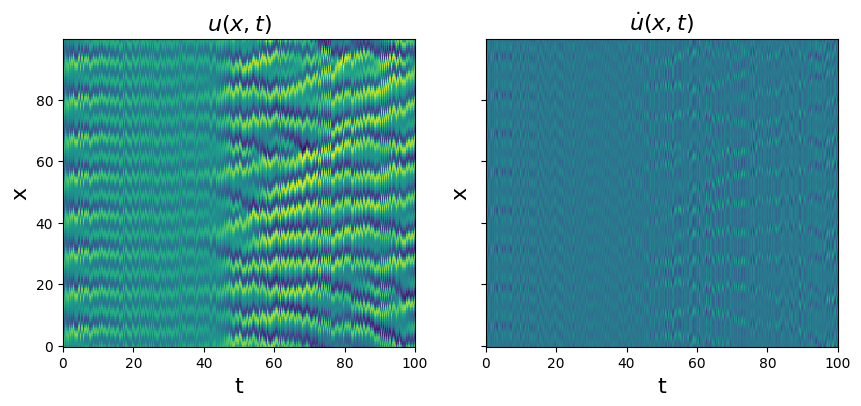

In [16]:
import h5py
from scipy.io import loadmat

with h5py.File("test_solving_euler_ks_spatial_shift.h5", "r") as f:
    u = np.array(f["u"])      # shape (Nt, Nx)
    x = np.array(f["x"])      # spatial grid
    t = np.array(f["t"])      # time grid


print("Shape of u : ", u.shape)
print("Shape of t: ", t.shape)
print("Shape of x: ", x.shape)


u = u.T

dt = t[1] - t[0]
dx = x[1] - x[0]

dt = dt.astype(np.float64)

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u, shading='auto')
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t), 1)
#u_dot = u_dot.reshape(len(x), len(t), 1)

In [17]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)

# Run optimizers

print("STLSQ optimizer: ")
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: ")
optimizer = ps.SR3(
    reg_weight_lam=0.8, max_iter=1000, regularizer="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:")
optimizer = ps.SR3(
    reg_weight_lam=0.2, max_iter=1000, regularizer="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with kappa=1e-20: ")
optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: ")
optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("FROLS optimizer: ")
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()

STLSQ optimizer: 
(x0)' = -0.014 x0 + -0.002 x0^2 + -1.020 x0_11 + -1.029 x0_1111 + -1.017 x0x0_1 + -0.003 x0x0_11 + -0.016 x0^2x0_11 + 0.045 x0x0_111 + -0.005 x0^2x0_1111
SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: 
(x0)' = -0.012 x0 + -1.022 x0_11 + -1.034 x0_1111 + -1.016 x0x0_1 + -0.024 x0^2x0_1 + -0.024 x0x0_11 + -0.010 x0^2x0_11 + 0.043 x0x0_111 + -0.024 x0x0_1111
SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:
(x0)' = 0.004 x0 + -0.782 x0_11 + -0.798 x0_1111 + -0.995 x0x0_1 + -0.005 x0^2x0_11
SSR optimizer with kappa=1e-20: 
(x0)' = 0.001 x0 + -0.972 x0_11 + -1.004 x0_1111 + -1.069 x0x0_1
SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: 
(x0)' = 0.003 x0 + -1.010 x0_11 + -0.009 x0_111 + -1.027 x0_1111 + -1.036 x0x0_1 + -0.004 x0^2x0_1 + -0.001 x0x0_11 + 0.028 x0x0_111 + 0.001 x0^2x0_111
FROLS optimizer: 
(x0)' = -0.014 x0 + -1.027 x0_11 + -1.036 x0_1111 + -1.007 x0x0_1 + -0.012 x0^2x0_11 + 0.048 x0x0_111 + 0.001 x0^2x0_111

### WeakSINDy on data with spatial translation between -10 to 10 pixels

Shape of u :  (2001, 200)
Shape of t:  (2001,)
Shape of x:  (200,)


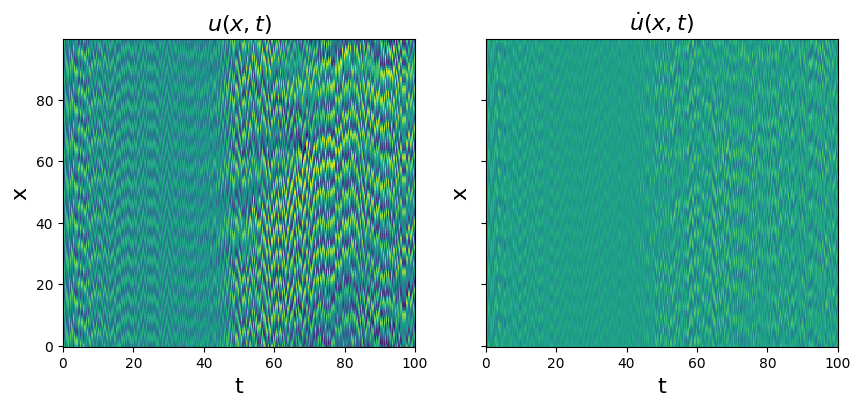

In [18]:
import h5py
from scipy.io import loadmat

with h5py.File("test_solving_euler_ks_spatial_shift_10.h5", "r") as f:
    u = np.array(f["u"])      # shape (Nt, Nx)
    x = np.array(f["x"])      # spatial grid
    t = np.array(f["t"])      # time grid


print("Shape of u : ", u.shape)
print("Shape of t: ", t.shape)
print("Shape of x: ", x.shape)


u = u.T

dt = t[1] - t[0]
dx = x[1] - x[0]

dt = dt.astype(np.float64)

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u, shading='auto')
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t), 1)
#u_dot = u_dot.reshape(len(x), len(t), 1)

In [19]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)

# Run optimizers

print("STLSQ optimizer: ")
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: ")
optimizer = ps.SR3(
    reg_weight_lam=0.8, max_iter=1000, regularizer="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:")
optimizer = ps.SR3(
    reg_weight_lam=0.2, max_iter=1000, regularizer="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with kappa=1e-20: ")
optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: ")
optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("FROLS optimizer: ")
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()

STLSQ optimizer: 
(x0)' = 0.055 x0 + -0.055 x0_1 + -0.813 x0_11 + -0.088 x0_111 + -0.796 x0_1111 + -0.796 x0x0_1 + -0.049 x0^2x0_11 + 0.057 x0x0_111 + -0.072 x0^2x0_1111
SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: 
(x0)' = 0.057 x0 + -0.730 x0_11 + -0.713 x0_1111 + -0.918 x0x0_1 + 0.017 x0x0_11 + -0.087 x0^2x0_11 + 0.017 x0x0_1111 + -0.111 x0^2x0_1111
SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:
(x0)' = 0.031 x0 + -0.472 x0_11 + -0.420 x0_1111 + -0.639 x0x0_1 + 0.006 x0x0_111 + -0.009 x0^2x0_1111
SSR optimizer with kappa=1e-20: 
(x0)' = -0.484 x0x0_1
SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: 
(x0)' = 0.062 x0 + 0.001 x0^2 + -0.058 x0_1 + -0.852 x0_11 + -0.126 x0_111 + -0.839 x0_1111 + -0.726 x0x0_1 + -0.004 x0^2x0_1 + 0.021 x0x0_11 + 0.076 x0x0_111 + -0.005 x0^2x0_111 + 0.016 x0x0_1111 + -0.030 x0^2x0_1111
FROLS optimizer: 
(x0)' = 0.057 x0 + -0.023 x0_1 + -0.809 x0_11 + -0.085 x0_111 + -0.789 x0_1111 + -0.807 x0x0_1 + 

### WeakSINDy on data with spatial translation between -20 to 20 pixels

Shape of u :  (2001, 200)
Shape of t:  (2001,)
Shape of x:  (200,)


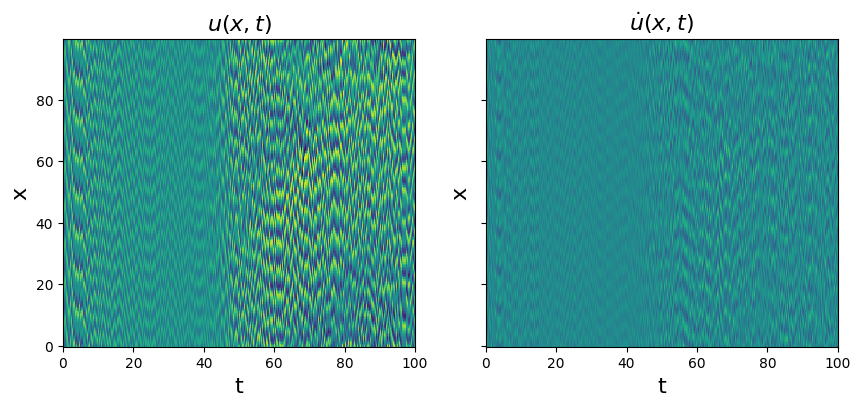

In [20]:
import h5py
from scipy.io import loadmat

with h5py.File("test_solving_euler_ks_spatial_shift_20.h5", "r") as f:
    u = np.array(f["u"])      # shape (Nt, Nx)
    x = np.array(f["x"])      # spatial grid
    t = np.array(f["t"])      # time grid


print("Shape of u : ", u.shape)
print("Shape of t: ", t.shape)
print("Shape of x: ", x.shape)


u = u.T

dt = t[1] - t[0]
dx = x[1] - x[0]

dt = dt.astype(np.float64)

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u, shading='auto')
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t), 1)
#u_dot = u_dot.reshape(len(x), len(t), 1)

In [21]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)

# Run optimizers

print("STLSQ optimizer: ")
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: ")
optimizer = ps.SR3(
    reg_weight_lam=0.8, max_iter=1000, regularizer="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:")
optimizer = ps.SR3(
    reg_weight_lam=0.2, max_iter=1000, regularizer="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with kappa=1e-20: ")
optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: ")
optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("FROLS optimizer: ")
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()

STLSQ optimizer: 
(x0)' = 0.035 x0 + 0.005 x0^2 + 0.170 x0_1 + -0.659 x0_11 + 0.233 x0_111 + -0.552 x0_1111 + -0.450 x0x0_1 + -0.003 x0x0_11 + 0.191 x0x0_111 + 0.010 x0^2x0_111
SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: 
(x0)' = -0.675 x0_11 + -0.551 x0_1111 + -0.599 x0x0_1 + -0.046 x0x0_11 + -0.078 x0^2x0_11 + 0.163 x0x0_111 + -0.042 x0x0_1111 + -0.064 x0^2x0_1111
SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:
(x0)' = 0.023 x0 + -0.070 x0_11 + -0.535 x0x0_1
SSR optimizer with kappa=1e-20: 
(x0)' = -0.509 x0x0_1
SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: 
(x0)' = 0.031 x0 + 0.004 x0^2 + 0.128 x0_1 + -0.628 x0_11 + 0.214 x0_111 + -0.514 x0_1111 + -0.542 x0x0_1 + 0.028 x0^2x0_1 + -0.005 x0x0_11 + -0.061 x0^2x0_11 + 0.172 x0x0_111 + 0.009 x0^2x0_111 + -0.057 x0^2x0_1111
FROLS optimizer: 
(x0)' = 0.036 x0 + 0.128 x0_1 + -0.676 x0_11 + 0.237 x0_111 + -0.580 x0_1111 + -0.467 x0x0_1 + -0.057 x0x0_11 + 0.186 x0x0_111 + 0.009 x0^2

### WeakSINDy on data with spatial translation between -30 to 30 pixels

Shape of u :  (2001, 200)
Shape of t:  (2001,)
Shape of x:  (200,)


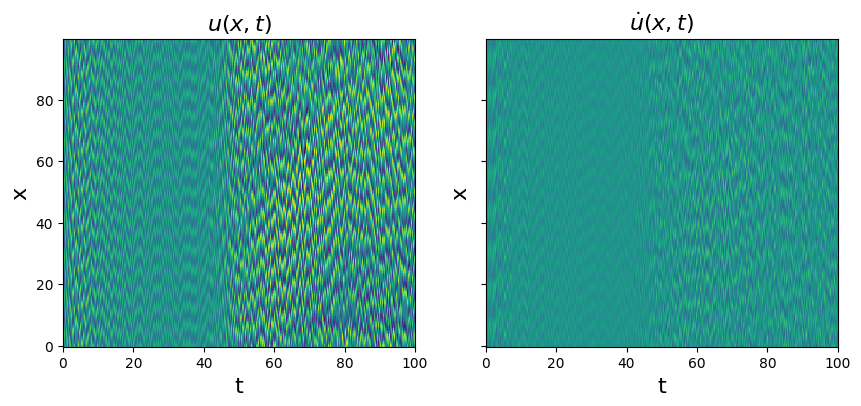

In [22]:
import h5py
from scipy.io import loadmat

with h5py.File("test_solving_euler_ks_spatial_shift_30.h5", "r") as f:
    u = np.array(f["u"])      # shape (Nt, Nx)
    x = np.array(f["x"])      # spatial grid
    t = np.array(f["t"])      # time grid


print("Shape of u : ", u.shape)
print("Shape of t: ", t.shape)
print("Shape of x: ", x.shape)


u = u.T

dt = t[1] - t[0]
dx = x[1] - x[0]

dt = dt.astype(np.float64)

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u, shading='auto')
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t), 1)
#u_dot = u_dot.reshape(len(x), len(t), 1)

In [23]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)

# Run optimizers

print("STLSQ optimizer: ")
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: ")
optimizer = ps.SR3(
    reg_weight_lam=0.8, max_iter=1000, regularizer="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:")
optimizer = ps.SR3(
    reg_weight_lam=0.2, max_iter=1000, regularizer="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with kappa=1e-20: ")
optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: ")
optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("FROLS optimizer: ")
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()

STLSQ optimizer: 
(x0)' = -0.185 x0_1 + -0.597 x0_11 + -0.620 x0_1111 + -0.500 x0x0_1 + 0.154 x0^2x0_1 + -0.007 x0^2x0_111
SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: 
(x0)' = -0.165 x0_1 + -1.030 x0_11 + -0.998 x0_1111 + 0.209 x0^2x0_1 + 0.104 x0x0_11 + 0.200 x0^2x0_11 + 0.202 x0x0_111 + -0.016 x0^2x0_111 + 0.098 x0x0_1111 + 0.185 x0^2x0_1111
SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:
(x0)' = -0.056 x0_11 + -0.207 x0x0_1
SSR optimizer with kappa=1e-20: 
(x0)' = -0.158 x0_1 + -1.002 x0_11 + -0.974 x0_1111 + -0.100 x0x0_1 + 0.201 x0^2x0_1 + 0.096 x0x0_11 + 0.176 x0^2x0_11 + 0.176 x0x0_111 + -0.015 x0^2x0_111 + 0.090 x0x0_1111 + 0.161 x0^2x0_1111
SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: 
(x0)' = 0.003 x0^2 + -0.154 x0_1 + -1.000 x0_11 + -0.971 x0_1111 + -0.097 x0x0_1 + 0.200 x0^2x0_1 + 0.103 x0x0_11 + 0.175 x0^2x0_11 + 0.177 x0x0_111 + -0.014 x0^2x0_111 + 0.093 x0x0_1111 + 0.160 x0^2x0_1111
FROLS optimizer: 
(x0)' = -0

### WeakSINDy on spatial translation between -40 to 40 pixels

Shape of u :  (2001, 200)
Shape of t:  (2001,)
Shape of x:  (200,)


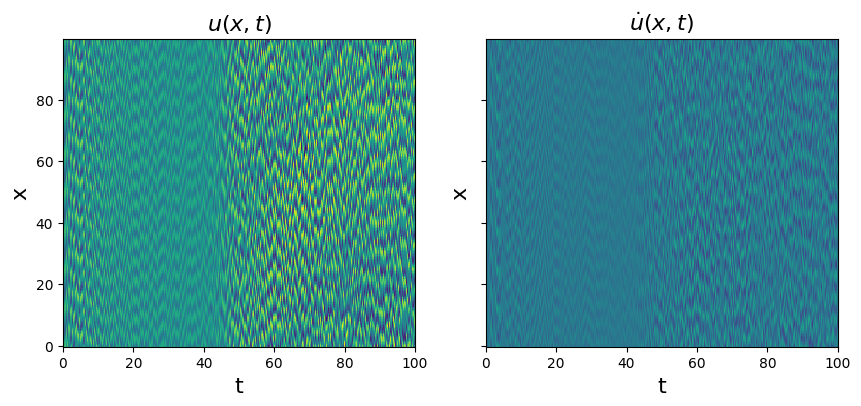

In [24]:
import h5py
from scipy.io import loadmat

with h5py.File("test_solving_euler_ks_spatial_shift_40.h5", "r") as f:
    u = np.array(f["u"])      # shape (Nt, Nx)
    x = np.array(f["x"])      # spatial grid
    t = np.array(f["t"])      # time grid


print("Shape of u : ", u.shape)
print("Shape of t: ", t.shape)
print("Shape of x: ", x.shape)


u = u.T

dt = t[1] - t[0]
dx = x[1] - x[0]

dt = dt.astype(np.float64)

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u, shading='auto')
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t), 1)
#u_dot = u_dot.reshape(len(x), len(t), 1)

In [25]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)

# Run optimizers

print("STLSQ optimizer: ")
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: ")
optimizer = ps.SR3(
    reg_weight_lam=0.8, max_iter=1000, regularizer="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:")
optimizer = ps.SR3(
    reg_weight_lam=0.2, max_iter=1000, regularizer="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with kappa=1e-20: ")
optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: ")
optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("FROLS optimizer: ")
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()

STLSQ optimizer: 
(x0)' = -0.395 x0_11 + 0.095 x0_111 + -0.515 x0_1111 + 0.071 x0^2x0_1 + -0.031 x0^2x0_11 + 0.165 x0x0_111 + 0.004 x0^2x0_111
SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: 
(x0)' = -0.097 x0 + -0.037 x0^2 + -0.391 x0_11 + -0.404 x0_1111 + -0.133 x0x0_11 + -0.215 x0^2x0_11 + 0.195 x0x0_111 + -0.079 x0x0_1111 + -0.135 x0^2x0_1111
SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:
(x0)' = -0.077 x0_1111 + 0.005 x0^2x0_1 + -0.012 x0^2x0_11 + 0.016 x0x0_111 + 0.001 x0^2x0_111
SSR optimizer with kappa=1e-20: 
(x0)' = -0.054 x0 + -0.015 x0^2 + 0.063 x0_1 + -0.472 x0_11 + 0.144 x0_111 + -0.537 x0_1111 + 0.216 x0x0_1 + 0.053 x0^2x0_1 + -0.026 x0x0_11 + -0.057 x0^2x0_11 + 0.240 x0x0_111 + 0.007 x0^2x0_111
SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: 
(x0)' = -0.026 x0^2 + 0.073 x0_1 + -0.374 x0_11 + 0.150 x0_111 + -0.463 x0_1111 + 0.154 x0x0_1 + -0.014 x0^2x0_1 + -0.107 x0x0_11 + -0.034 x0^2x0_11 + 0.206 x0x0_111 + 0.004 x0

### WeakSINDy on spatially translated data between -50 to 50 pixels

Shape of u :  (2001, 200)
Shape of t:  (2001,)
Shape of x:  (200,)


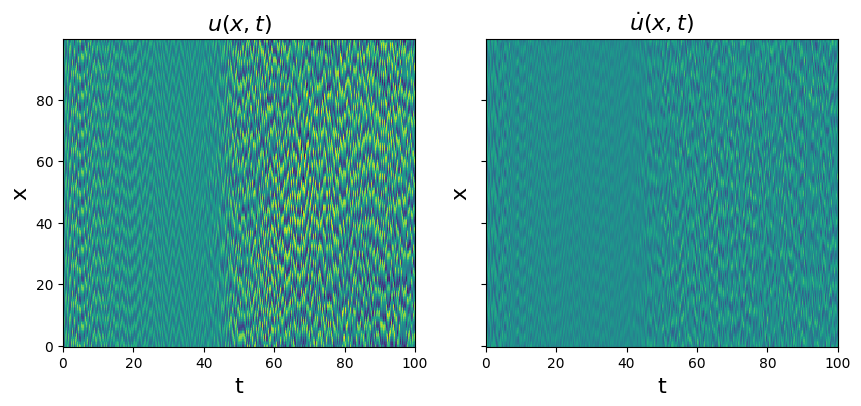

In [26]:
import h5py
from scipy.io import loadmat

with h5py.File("test_solving_euler_ks_spatial_shift_50.h5", "r") as f:
    u = np.array(f["u"])      # shape (Nt, Nx)
    x = np.array(f["x"])      # spatial grid
    t = np.array(f["t"])      # time grid


print("Shape of u : ", u.shape)
print("Shape of t: ", t.shape)
print("Shape of x: ", x.shape)


u = u.T

dt = t[1] - t[0]
dx = x[1] - x[0]

dt = dt.astype(np.float64)

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u, shading='auto')
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t), 1)
#u_dot = u_dot.reshape(len(x), len(t), 1)

In [27]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)

# Run optimizers

print("STLSQ optimizer: ")
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: ")
optimizer = ps.SR3(
    reg_weight_lam=0.8, max_iter=1000, regularizer="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:")
optimizer = ps.SR3(
    reg_weight_lam=0.2, max_iter=1000, regularizer="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with kappa=1e-20: ")
optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: ")
optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("FROLS optimizer: ")
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()

STLSQ optimizer: 
(x0)' = 0.030 x0 + 0.231 x0_1 + -0.180 x0^2x0_1 + 0.018 x0^2x0_111 + 0.008 x0x0_1111
SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: 
(x0)' = 0.021 x0^2 + 0.263 x0_1 + -0.115 x0^2x0_1 + 0.123 x0x0_11 + 0.023 x0^2x0_111 + 0.102 x0x0_1111
SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:
(x0)' = 0.003 x0
SSR optimizer with kappa=1e-20: 
(x0)' = -0.013 x0^2x0_1
SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: 
(x0)' = 0.023 x0
FROLS optimizer: 
(x0)' = 0.091 x0 + 0.022 x0^2 + 0.333 x0_1 + 0.079 x0_11 + 0.088 x0_111 + -0.137 x0^2x0_1 + 0.128 x0x0_11 + 0.021 x0^2x0_11 + 0.022 x0^2x0_111 + 0.104 x0x0_1111


## WeakSINDy on our noisy data (2% gaussian noise added to every time step)

Shape of u :  (2001, 200)
Shape of t:  (2001,)
Shape of x:  (200,)


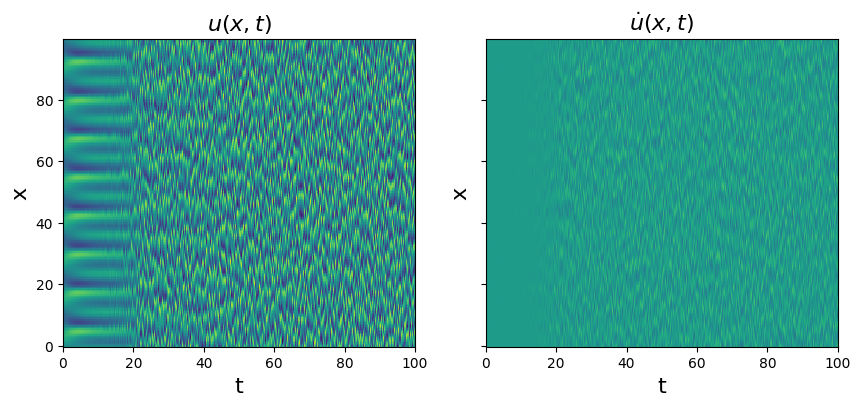

In [42]:
import h5py
from scipy.io import loadmat

with h5py.File("test_solving_euler_ks_varied_ic.h5", "r") as f:
    u = np.array(f["u"])      # shape (Nt, Nx)
    x = np.array(f["x"])      # spatial grid
    t = np.array(f["t"])      # time grid


print("Shape of u : ", u.shape)
print("Shape of t: ", t.shape)
print("Shape of x: ", x.shape)


u = u.T

dt = t[1] - t[0]
dx = x[1] - x[0]

dt = dt.astype(np.float64)

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u, shading='auto')
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t),1)

In [43]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)


# Run optimizers

print("STLSQ optimizer: ")
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: ")
optimizer = ps.SR3(
    reg_weight_lam=0.8, max_iter=1000, regularizer="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:")
optimizer = ps.SR3(
    reg_weight_lam=0.2, max_iter=1000, regularizer="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with kappa=1e-20: ")
optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: ")
optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("FROLS optimizer: ")
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


STLSQ optimizer: 
(x0)' = -0.268 x0 + 0.017 x0^2 + 0.079 x0_1 + -0.664 x0_11 + 0.059 x0_111 + -0.497 x0_1111 + -0.744 x0x0_1 + 0.001 x0x0_11 + -0.485 x0^2x0_11 + 0.032 x0^2x0_111 + -0.346 x0^2x0_1111
SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: 
(x0)' = -0.255 x0 + -0.008 x0^2 + -0.716 x0_11 + -0.553 x0_1111 + -0.605 x0x0_1 + -0.108 x0^2x0_1 + -0.179 x0x0_11 + -0.496 x0^2x0_11 + 0.119 x0x0_111 + 0.022 x0^2x0_111 + -0.148 x0x0_1111 + -0.333 x0^2x0_1111
SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:
(x0)' = 0.001 x0_1 + -0.051 x0_1111 + -0.432 x0x0_1 + -0.034 x0^2x0_11
SSR optimizer with kappa=1e-20: 
(x0)' = -0.267 x0 + 0.017 x0^2 + 0.117 x0_1 + -0.649 x0_11 + 0.080 x0_111 + -0.486 x0_1111 + -0.736 x0x0_1 + -0.039 x0^2x0_1 + 0.002 x0x0_11 + -0.480 x0^2x0_11 + 0.033 x0^2x0_111 + -0.340 x0^2x0_1111
SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: 
(x0)' = -0.245 x0 + -0.016 x0^2 + 0.082 x0_1 + -0.614 x0_11 + 0.062 x0_111 + -0.465 x0

Fails miserably with gaussian noise

### WeakSINDy on noisy data: 5% gaussian noise added to every time step

Shape of u :  (2001, 200)
Shape of t:  (2001,)
Shape of x:  (200,)


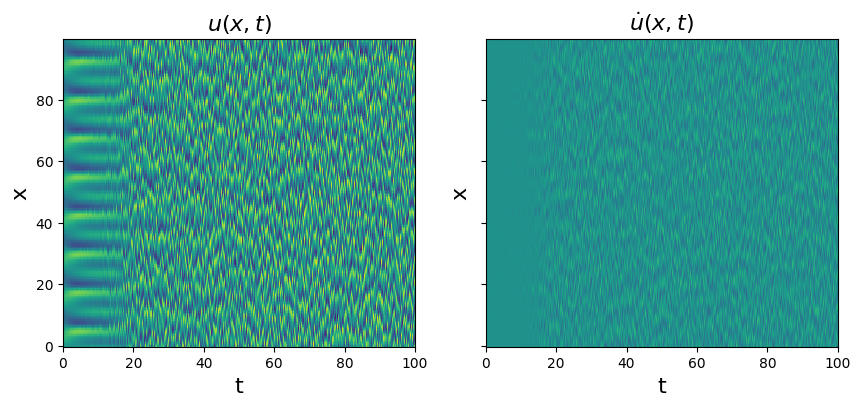

In [61]:
import h5py
from scipy.io import loadmat

with h5py.File("test_solving_euler_ks_varied_ic_5.h5", "r") as f:
    u = np.array(f["u"])      # shape (Nt, Nx)
    x = np.array(f["x"])      # spatial grid
    t = np.array(f["t"])      # time grid


print("Shape of u : ", u.shape)
print("Shape of t: ", t.shape)
print("Shape of x: ", x.shape)


u = u.T

dt = t[1] - t[0]
dx = x[1] - x[0]

dt = dt.astype(np.float64)

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u, shading='auto')
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t),1)

In [62]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)

# Run optimizers

print("STLSQ optimizer: ")
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: ")
optimizer = ps.SR3(
    reg_weight_lam=0.8, max_iter=1000, regularizer="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:")
optimizer = ps.SR3(
    reg_weight_lam=0.2, max_iter=1000, regularizer="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with kappa=1e-20: ")
optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: ")
optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("FROLS optimizer: ")
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()

STLSQ optimizer: 
(x0)' = -0.717 x0_11 + -0.013 x0_111 + -0.727 x0_1111 + -0.945 x0x0_1 + -0.020 x0^2x0_1 + -0.188 x0^2x0_11 + -0.168 x0^2x0_1111
SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: 
(x0)' = -0.132 x0 + 0.018 x0^2 + -1.054 x0_11 + -0.958 x0_1111 + -0.767 x0x0_1 + 0.093 x0x0_11 + -0.230 x0^2x0_11 + 0.086 x0x0_111 + 0.061 x0x0_1111 + -0.161 x0^2x0_1111
SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:
(x0)' = -0.098 x0_1111 + -0.473 x0x0_1 + -0.044 x0^2x0_11
SSR optimizer with kappa=1e-20: 
(x0)' = -0.109 x0 + 0.017 x0^2 + -0.012 x0_1 + -0.927 x0_11 + -0.031 x0_111 + -0.861 x0_1111 + -0.889 x0x0_1 + 0.060 x0^2x0_1 + 0.124 x0x0_11 + -0.224 x0^2x0_11 + 0.001 x0^2x0_111 + 0.096 x0x0_1111 + -0.174 x0^2x0_1111
SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: 
(x0)' = 0.007 x0^2 + 0.022 x0_1 + -0.849 x0_11 + -0.016 x0_111 + -0.890 x0_1111 + -0.727 x0x0_1 + 0.003 x0^2x0_1 + 0.083 x0x0_11 + -0.009 x0^2x0_11 + 0.054 x0x0_111 + -0.003 

### WeakSINDy on noisy data: 10% gaussian noise added to every time step

Shape of u :  (2001, 200)
Shape of t:  (2001,)
Shape of x:  (200,)


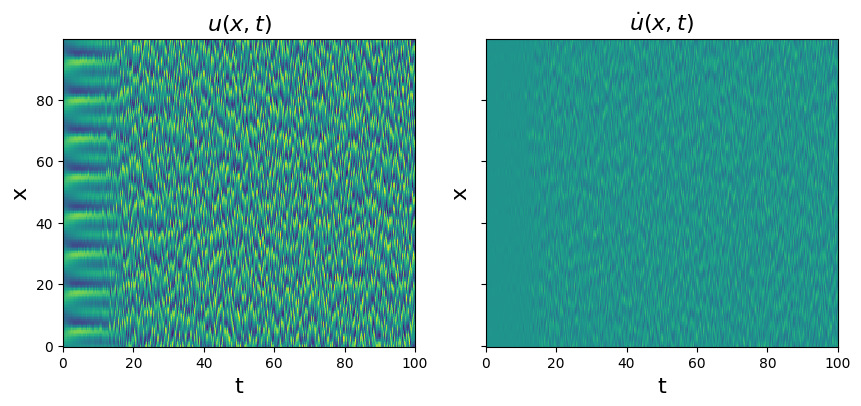

In [63]:
import h5py
from scipy.io import loadmat

with h5py.File("test_solving_euler_ks_varied_ic_10.h5", "r") as f:
    u = np.array(f["u"])      # shape (Nt, Nx)
    x = np.array(f["x"])      # spatial grid
    t = np.array(f["t"])      # time grid


print("Shape of u : ", u.shape)
print("Shape of t: ", t.shape)
print("Shape of x: ", x.shape)


u = u.T

dt = t[1] - t[0]
dx = x[1] - x[0]

dt = dt.astype(np.float64)

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u, shading='auto')
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t),1)

In [64]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)

# Run optimizers

print("STLSQ optimizer: ")
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: ")
optimizer = ps.SR3(
    reg_weight_lam=0.8, max_iter=1000, regularizer="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:")
optimizer = ps.SR3(
    reg_weight_lam=0.2, max_iter=1000, regularizer="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with kappa=1e-20: ")
optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: ")
optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("FROLS optimizer: ")
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()

STLSQ optimizer: 
(x0)' = 0.054 x0_1 + 0.041 x0_111 + -0.087 x0_1111 + -0.474 x0x0_1 + 0.105 x0^2x0_1 + -0.045 x0x0_11 + -0.120 x0^2x0_11 + 0.069 x0x0_111 + 0.058 x0^2x0_111 + 0.004 x0x0_1111 + -0.040 x0^2x0_1111
SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: 
(x0)' = -0.084 x0 + -0.113 x0^2 + -0.297 x0_11 + -0.332 x0_1111 + -0.328 x0x0_1 + -0.361 x0x0_11 + -0.105 x0^2x0_11 + 0.125 x0x0_111 + -0.172 x0x0_1111
SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:
(x0)' = -0.047 x0_1111 + -0.423 x0x0_1 + 0.029 x0^2x0_1 + -0.033 x0^2x0_11
SSR optimizer with kappa=1e-20: 
(x0)' = -0.356 x0x0_1
SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: 
(x0)' = -0.086 x0 + -0.116 x0^2 + 0.007 x0_1 + -0.272 x0_11 + 0.071 x0_111 + -0.320 x0_1111 + -0.314 x0x0_1 + 0.013 x0^2x0_1 + -0.364 x0x0_11 + -0.107 x0^2x0_11 + 0.123 x0x0_111 + -0.005 x0^2x0_111 + -0.173 x0x0_1111
FROLS optimizer: 
(x0)' = -0.124 x0 + -0.519 x0_11 + 0.041 x0_111 + -0.517 x0_1111 + -0.

### WeakSINDy on noisy data: 15% gaussian noise added to every time step

Shape of u :  (2001, 200)
Shape of t:  (2001,)
Shape of x:  (200,)


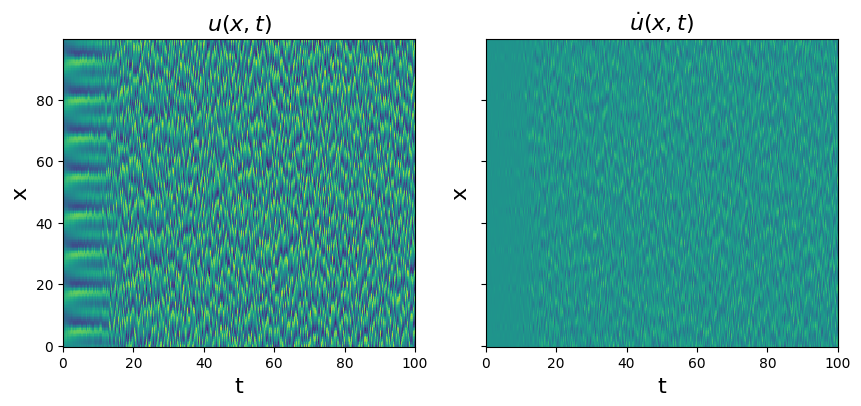

In [49]:
import h5py
from scipy.io import loadmat

with h5py.File("test_solving_euler_ks_varied_ic_15.h5", "r") as f:
    u = np.array(f["u"])      # shape (Nt, Nx)
    x = np.array(f["x"])      # spatial grid
    t = np.array(f["t"])      # time grid


print("Shape of u : ", u.shape)
print("Shape of t: ", t.shape)
print("Shape of x: ", x.shape)


u = u.T

dt = t[1] - t[0]
dx = x[1] - x[0]

dt = dt.astype(np.float64)

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u, shading='auto')
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t),1)

In [50]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)

# Run optimizers

print("STLSQ optimizer: ")
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: ")
optimizer = ps.SR3(
    reg_weight_lam=0.8, max_iter=1000, regularizer="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:")
optimizer = ps.SR3(
    reg_weight_lam=0.2, max_iter=1000, regularizer="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with kappa=1e-20: ")
optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: ")
optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("FROLS optimizer: ")
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()

STLSQ optimizer: 
(x0)' = -0.167 x0 + 0.026 x0^2 + 0.056 x0_111 + -0.038 x0_1111 + -0.447 x0x0_1 + 0.005 x0^2x0_1 + -0.129 x0x0_11 + -0.185 x0^2x0_11 + 0.071 x0^2x0_111 + -0.112 x0x0_1111 + -0.068 x0^2x0_1111
SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: 
(x0)' = -0.223 x0 + 0.011 x0^2 + -0.081 x0_1 + -0.435 x0_11 + -0.400 x0_1111 + -0.456 x0x0_1 + -0.192 x0x0_11 + -0.135 x0^2x0_11 + 0.059 x0^2x0_111 + -0.158 x0x0_1111 + -0.037 x0^2x0_1111
SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:
(x0)' = 0.016 x0_111 + -0.072 x0_1111 + -0.481 x0x0_1 + 0.007 x0^2x0_1 + -0.020 x0^2x0_11
SSR optimizer with kappa=1e-20: 
(x0)' = -0.167 x0 + 0.026 x0^2 + 0.056 x0_111 + -0.038 x0_1111 + -0.447 x0x0_1 + 0.005 x0^2x0_1 + -0.129 x0x0_11 + -0.185 x0^2x0_11 + 0.071 x0^2x0_111 + -0.112 x0x0_1111 + -0.068 x0^2x0_1111
SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: 
(x0)' = -0.157 x0 + 0.016 x0^2 + -0.067 x0_1 + 0.020 x0_111 + -0.054 x0_1111 + -0.373 x0x

### WeakSINDy on noisy data: 20% gaussian noise added to every time step

Shape of u :  (2001, 200)
Shape of t:  (2001,)
Shape of x:  (200,)


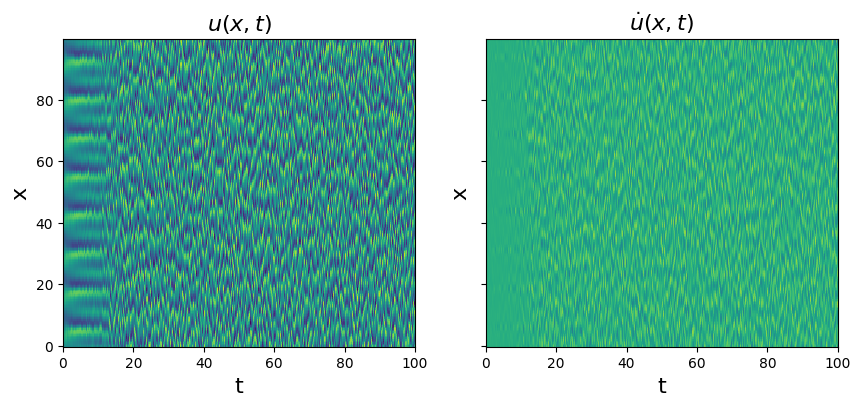

In [59]:
import h5py
from scipy.io import loadmat

with h5py.File("test_solving_euler_ks_varied_ic_20.h5", "r") as f:
    u = np.array(f["u"])      # shape (Nt, Nx)
    x = np.array(f["x"])      # spatial grid
    t = np.array(f["t"])      # time grid


print("Shape of u : ", u.shape)
print("Shape of t: ", t.shape)
print("Shape of x: ", x.shape)


u = u.T

dt = t[1] - t[0]
dx = x[1] - x[0]

dt = dt.astype(np.float64)

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u, shading='auto')
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t),1)

In [60]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)

# Run optimizers

print("STLSQ optimizer: ")
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: ")
optimizer = ps.SR3(
    reg_weight_lam=0.8, max_iter=1000, regularizer="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:")
optimizer = ps.SR3(
    reg_weight_lam=0.2, max_iter=1000, regularizer="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with kappa=1e-20: ")
optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: ")
optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()


print("FROLS optimizer: ")
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, dt)
model.print()

STLSQ optimizer: 
(x0)' = 0.058 x0_1 + -0.009 x0_111 + -0.025 x0_1111 + -0.536 x0x0_1 + -0.153 x0^2x0_1 + 0.008 x0x0_11 + -0.014 x0^2x0_11 + -0.026 x0x0_111 + -0.039 x0^2x0_111 + -0.029 x0x0_1111
SR3 optimizer with l0 regularizer. reg_weight_lam 0.8: 
(x0)' = -0.034 x0^2 + -0.815 x0x0_1 + -0.123 x0^2x0_1 + -0.078 x0x0_11 + -0.181 x0^2x0_11 + -0.090 x0x0_111 + -0.054 x0^2x0_111 + -0.069 x0x0_1111 + -0.164 x0^2x0_1111
SR3 optimizer with l1 regularizer, reg_weight_lam 0.2:
(x0)' = -0.437 x0x0_1 + -0.001 x0^2x0_11
SSR optimizer with kappa=1e-20: 
(x0)' = -0.016 x0^2 + 0.053 x0_1 + -0.003 x0_111 + -0.023 x0_1111 + -0.528 x0x0_1 + -0.160 x0^2x0_1 + -0.029 x0x0_11 + -0.014 x0^2x0_11 + -0.025 x0x0_111 + -0.048 x0^2x0_111 + -0.046 x0x0_1111
SSR optimizer with criteria=model_residual and kappa 1e_20 and normalized_columns True: 
(x0)' = -0.028 x0^2 + 0.039 x0_1 + -0.015 x0_111 + -0.012 x0_1111 + -0.665 x0x0_1 + -0.165 x0^2x0_1 + -0.071 x0x0_11 + -0.187 x0^2x0_11 + -0.049 x0^2x0_111 + -0.069 x0x0

### Plotting the results

<Figure size 1000x600 with 0 Axes>

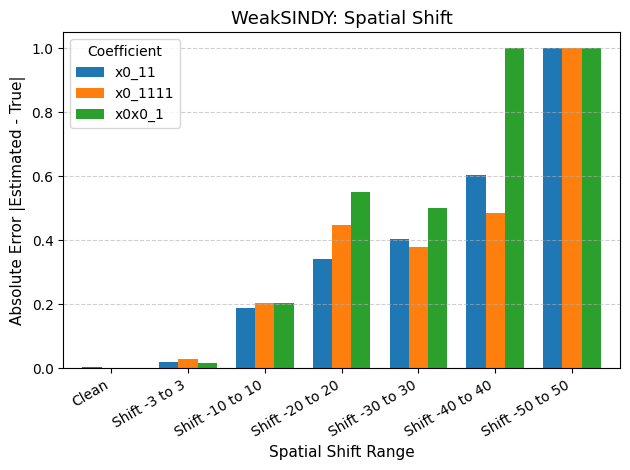

<Figure size 1000x600 with 0 Axes>

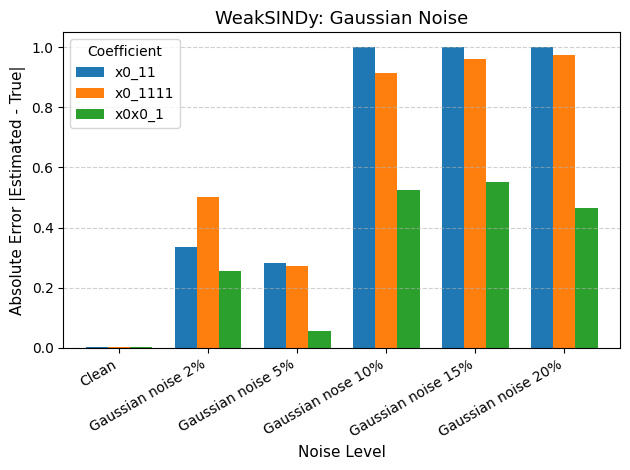

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Ground truth values
true_vals = {'x0_11': -1, 'x0_1111': -1, 'x0x0_1': -1}

# STLSQ estimated coefficients for each dataset
data = {
    'Clean':              {'x0_11': -1.003, 'x0_1111': -1.002, 'x0x0_1': -0.999},
    'Shift -3 to 3':      {'x0_11': -1.020, 'x0_1111': -1.029, 'x0x0_1': -1.017},
    'Shift -10 to 10':    {'x0_11': -0.813, 'x0_1111': -0.796, 'x0x0_1': -0.796},
    'Shift -20 to 20':    {'x0_11': -0.659, 'x0_1111': -0.552, 'x0x0_1': -0.450},
    'Shift -30 to 30':    {'x0_11': -0.597, 'x0_1111': -0.620, 'x0x0_1': -0.500},
    'Shift -40 to 40':    {'x0_11': -0.395, 'x0_1111': -0.515, 'x0x0_1': 0},  
    'Shift -50 to 50':    {'x0_11': 0, 'x0_1111': 0, 'x0x0_1': 0},      
    'Gaussian noise 2%':  {'x0_11': -0.664, 'x0_1111': -0.497, 'x0x0_1': -0.744}, 
    "Gaussian noise 5%": {"x0_11": -0.717 , "x0_1111": -0.727 , "x0x0_1": -0.945},
    "Gaussian nose 10%": {"x0_11": 0, "x0_1111": -0.087, "x0x0_1": -0.474},
    "Gaussian noise 15%": {"x0_11": 0, "x0_1111": -0.038, "x0x0_1": -0.447},
    "Gaussian noise 20%": {"x0_11": 0, "x0_1111": -0.025, "x0x0_1": -0.536}
}

# Convert to DataFrame
df = pd.DataFrame(data).T

# Compute absolute errors vs ground truth
for coeff in true_vals:
    df[f'{coeff}_err'] = abs(df[coeff] - true_vals[coeff])

# --- Clean vs Spatial Shift ---
spatial_shift_df = df.loc[['Clean',
                           'Shift -3 to 3',
                           'Shift -10 to 10',
                           'Shift -20 to 20',
                           'Shift -30 to 30',
                           'Shift -40 to 40',
                           'Shift -50 to 50'],
                          [f'{k}_err' for k in true_vals.keys()]]

plt.figure(figsize=(10, 6))
spatial_shift_df.plot(kind='bar', width=0.75)
plt.title('WeakSINDY: Spatial Shift', fontsize=13)
plt.ylabel('Absolute Error |Estimated - True|', fontsize=11)
plt.xlabel('Spatial Shift Range', fontsize=11)
plt.xticks(rotation=30, ha='right')
plt.legend(['x0_11', 'x0_1111', 'x0x0_1'], title='Coefficient')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Clean vs Gaussian Noise ---
gaussian_df = df.loc[['Clean',
                      'Gaussian noise 2%',
                      'Gaussian noise 5%',
                      'Gaussian nose 10%',
                      'Gaussian noise 15%',
                      'Gaussian noise 20%'],
                     [f'{k}_err' for k in true_vals.keys()]]

plt.figure(figsize=(10, 6))
gaussian_df.plot(kind='bar', width=0.75)
plt.title('WeakSINDy: Gaussian Noise', fontsize=13)
plt.ylabel('Absolute Error |Estimated - True|', fontsize=11)
plt.xlabel('Noise Level', fontsize=11)
plt.xticks(rotation=30, ha='right')
plt.legend(['x0_11', 'x0_1111', 'x0x0_1'], title='Coefficient')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



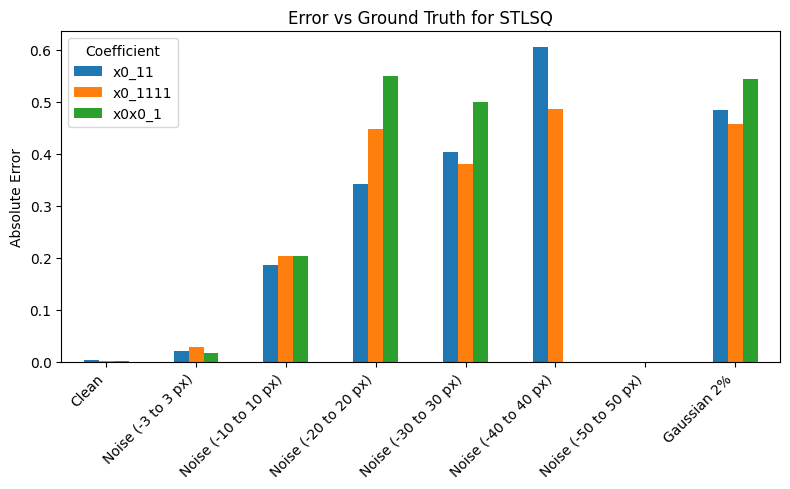

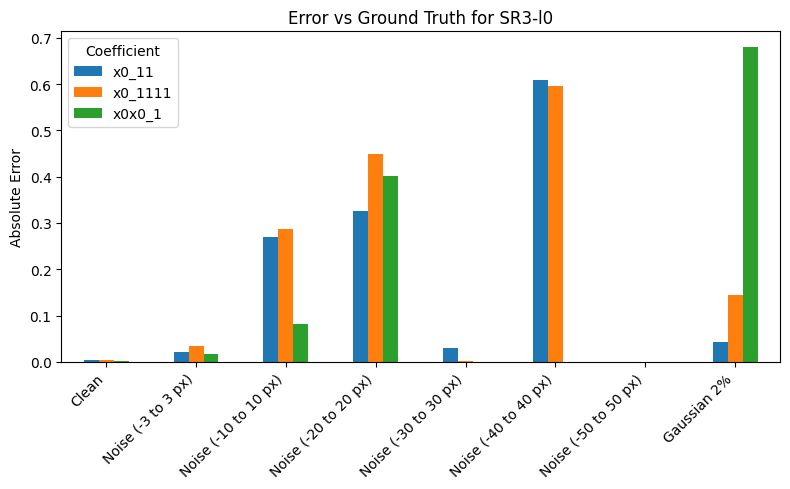

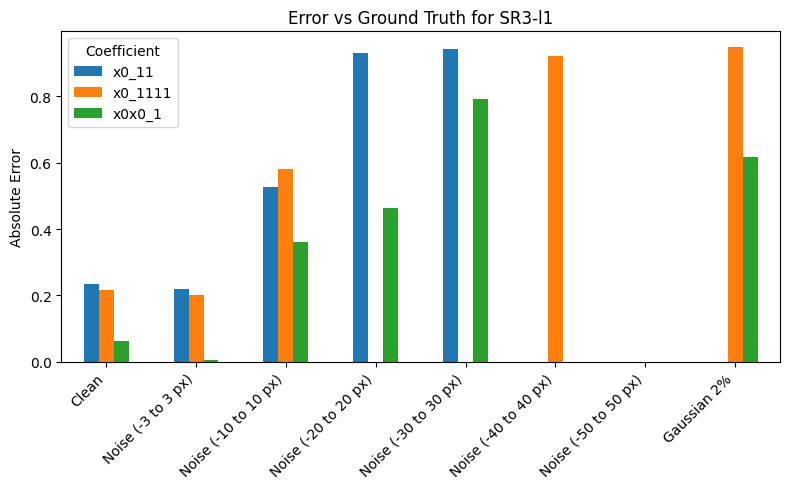

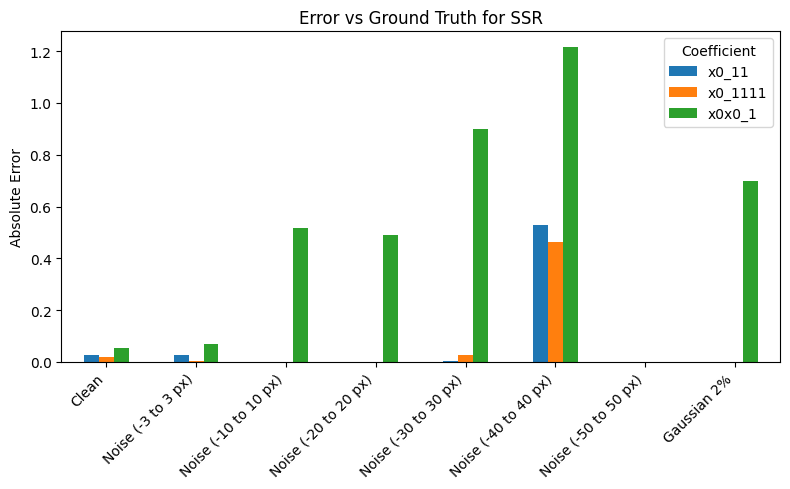

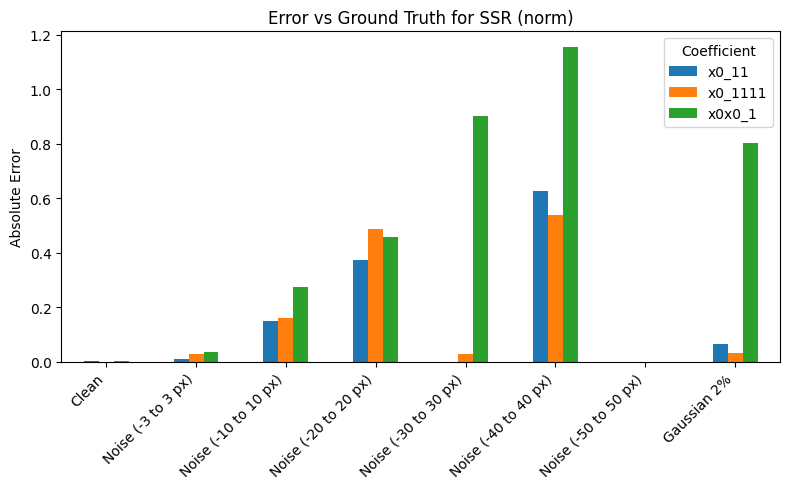

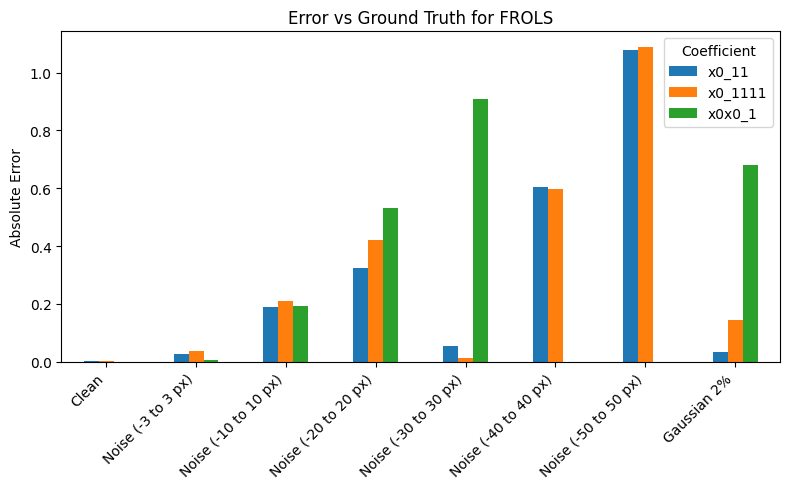

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ground truth values for the three coefficients
true_vals = {'x0_11': -1.0, 'x0_1111': -1.0, 'x0x0_1': -1.0}

# Define all datasets (you can add more if you expand later)
datasets = [
    "Clean",
    "Noise (-3 to 3 px)",
    "Noise (-10 to 10 px)",
    "Noise (-20 to 20 px)",
    "Noise (-30 to 30 px)",
    "Noise (-40 to 40 px)",
    "Noise (-50 to 50 px)",
    "Gaussian 2%",
]

# Estimated coefficients for each optimizer (for only the 3 relevant terms)
# ---- Fill these manually from your text ----
coeffs = {
    "STLSQ": {
        "Clean":       {'x0_11': -1.003, 'x0_1111': -1.002, 'x0x0_1': -0.999},
        "Noise (-3 to 3 px)": {'x0_11': -1.020, 'x0_1111': -1.029, 'x0x0_1': -1.017},
        "Noise (-10 to 10 px)": {'x0_11': -0.813, 'x0_1111': -0.796, 'x0x0_1': -0.796},
        "Noise (-20 to 20 px)": {'x0_11': -0.659, 'x0_1111': -0.552, 'x0x0_1': -0.450},
        "Noise (-30 to 30 px)": {'x0_11': -0.597, 'x0_1111': -0.620, 'x0x0_1': -0.500},
        "Noise (-40 to 40 px)": {'x0_11': -0.395, 'x0_1111': -0.515, 'x0x0_1': np.nan},
        "Noise (-50 to 50 px)": {'x0_11': np.nan, 'x0_1111': np.nan, 'x0x0_1': np.nan},
        "Gaussian 2%": {'x0_11': -0.516, 'x0_1111': -0.543, 'x0x0_1': -0.456},
    },
    "SR3-l0": {
        "Clean": {'x0_11': -1.004, 'x0_1111': -1.003, 'x0x0_1': -1.002},
        "Noise (-3 to 3 px)": {'x0_11': -1.022, 'x0_1111': -1.034, 'x0x0_1': -1.016},
        "Noise (-10 to 10 px)": {'x0_11': -0.730, 'x0_1111': -0.713, 'x0x0_1': -0.918},
        "Noise (-20 to 20 px)": {'x0_11': -0.675, 'x0_1111': -0.551, 'x0x0_1': -0.599},
        "Noise (-30 to 30 px)": {'x0_11': -1.030, 'x0_1111': -0.998, 'x0x0_1': np.nan},
        "Noise (-40 to 40 px)": {'x0_11': -0.391, 'x0_1111': -0.404, 'x0x0_1': np.nan},
        "Noise (-50 to 50 px)": {'x0_11': np.nan, 'x0_1111': np.nan, 'x0x0_1': np.nan},
        "Gaussian 2%": {'x0_11': -0.958, 'x0_1111': -0.856, 'x0x0_1': -0.320},
    },
    "SR3-l1": {
        "Clean": {'x0_11': -0.766, 'x0_1111': -0.785, 'x0x0_1': -0.938},
        "Noise (-3 to 3 px)": {'x0_11': -0.782, 'x0_1111': -0.798, 'x0x0_1': -0.995},
        "Noise (-10 to 10 px)": {'x0_11': -0.472, 'x0_1111': -0.420, 'x0x0_1': -0.639},
        "Noise (-20 to 20 px)": {'x0_11': -0.070, 'x0_1111': np.nan, 'x0x0_1': -0.535},
        "Noise (-30 to 30 px)": {'x0_11': -0.056, 'x0_1111': np.nan, 'x0x0_1': -0.207},
        "Noise (-40 to 40 px)": {'x0_11': np.nan, 'x0_1111': -0.077, 'x0x0_1': np.nan},
        "Noise (-50 to 50 px)": {'x0_11': np.nan, 'x0_1111': np.nan, 'x0x0_1': np.nan},
        "Gaussian 2%": {'x0_11': np.nan, 'x0_1111': -0.051, 'x0x0_1': -0.382},
    },
    "SSR": {
        "Clean": {'x0_11': -0.973, 'x0_1111': -0.983, 'x0x0_1': -1.055},
        "Noise (-3 to 3 px)": {'x0_11': -0.972, 'x0_1111': -1.004, 'x0x0_1': -1.069},
        "Noise (-10 to 10 px)": {'x0_11': np.nan, 'x0_1111': np.nan, 'x0x0_1': -0.484},
        "Noise (-20 to 20 px)": {'x0_11': np.nan, 'x0_1111': np.nan, 'x0x0_1': -0.509},
        "Noise (-30 to 30 px)": {'x0_11': -1.002, 'x0_1111': -0.974, 'x0x0_1': -0.100},
        "Noise (-40 to 40 px)": {'x0_11': -0.472, 'x0_1111': -0.537, 'x0x0_1': 0.216},
        "Noise (-50 to 50 px)": {'x0_11': np.nan, 'x0_1111': np.nan, 'x0x0_1': np.nan},
        "Gaussian 2%": {'x0_11': np.nan, 'x0_1111': np.nan, 'x0x0_1': -0.301},
    },
    "SSR (norm)": {
        "Clean": {'x0_11': -1.002, 'x0_1111': -1.001, 'x0x0_1': -1.002},
        "Noise (-3 to 3 px)": {'x0_11': -1.010, 'x0_1111': -1.027, 'x0x0_1': -1.036},
        "Noise (-10 to 10 px)": {'x0_11': -0.852, 'x0_1111': -0.839, 'x0x0_1': -0.726},
        "Noise (-20 to 20 px)": {'x0_11': -0.628, 'x0_1111': -0.514, 'x0x0_1': -0.542},
        "Noise (-30 to 30 px)": {'x0_11': -1.000, 'x0_1111': -0.971, 'x0x0_1': -0.097},
        "Noise (-40 to 40 px)": {'x0_11': -0.374, 'x0_1111': -0.463, 'x0x0_1': 0.154},
        "Noise (-50 to 50 px)": {'x0_11': np.nan, 'x0_1111': np.nan, 'x0x0_1': np.nan},
        "Gaussian 2%": {'x0_11': -1.064, 'x0_1111': -0.968, 'x0x0_1': -0.197},
    },
    "FROLS": {
        "Clean": {'x0_11': -1.003, 'x0_1111': -1.002, 'x0x0_1': -1.000},
        "Noise (-3 to 3 px)": {'x0_11': -1.027, 'x0_1111': -1.036, 'x0x0_1': -1.007},
        "Noise (-10 to 10 px)": {'x0_11': -0.809, 'x0_1111': -0.789, 'x0x0_1': -0.807},
        "Noise (-20 to 20 px)": {'x0_11': -0.676, 'x0_1111': -0.580, 'x0x0_1': -0.467},
        "Noise (-30 to 30 px)": {'x0_11': -1.054, 'x0_1111': -0.988, 'x0x0_1': -0.093},
        "Noise (-40 to 40 px)": {'x0_11': -0.397, 'x0_1111': -0.401, 'x0x0_1': np.nan},
        "Noise (-50 to 50 px)": {'x0_11': 0.079, 'x0_1111': 0.088, 'x0x0_1': np.nan},
        "Gaussian 2%": {'x0_11': -0.966, 'x0_1111': -0.857, 'x0x0_1': -0.321},
    },
}

# --- Create plots ---
for optimizer, data in coeffs.items():
    df = pd.DataFrame(data).T
    errors = abs(df - pd.Series(true_vals))
    
    plt.figure(figsize=(8,5))
    errors.plot(kind='bar', ax=plt.gca())
    plt.title(f"Error vs Ground Truth for {optimizer}")
    plt.ylabel("Absolute Error")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Coefficient")
    plt.tight_layout()
    plt.show()
